In [0]:
import os
import numpy as np
import pandas as pd
from skimage import io
from skimage.transform import resize
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, Concatenate, UpSampling2D
from keras.layers import BatchNormalization, Activation, Conv2D,MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, load_model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import time
import random

def load_data(img_shape):
    path = r'data'
    fileNames = [f for f in sorted(os.listdir(path))]
    images = np.array([np.array(resize(io.imread(path + '/' + f, as_grey=True), (img_shape[0],img_shape[1]))) for f in fileNames])

    #reshape
    images = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1)
    labels = np.array([f.split('.')[0].split('_')[2] for f in fileNames])
    return images, labels

def generate_noise(n_samples, noise_dim):
    return np.random.normal(0, 1, size=(n_samples, noise_dim))

def generate_random_labels(labels_num, n):
    z = np.zeros((n, labels_num))
    x = np.random.choice(labels_num, n)
    for i in range(n):    
        z[i, x[i]] = 1    
    return z

def create_encoder(input_shape, encoding_shape):
    e_in = Input(shape=input_shape)
    
    # Encoder
    hid = Conv2D(32, 5, padding='same')(e_in)
    hid = LeakyReLU(alpha=0.2)(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = MaxPooling2D((2,2))(hid)
    
    hid = Conv2D(64, 5, padding='same')(hid)
    hid = LeakyReLU(alpha=0.2)(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = MaxPooling2D((2,2))(hid)
    
    hid = Conv2D(128, 3, padding='same')(hid)
    hid = MaxPooling2D((2,2))(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)
    
#     hid = Conv2D(256, 3, padding='same')(hid)
#     hid = MaxPooling2D((2,2))(hid)
#     hid = BatchNormalization(momentum=0.9)(hid)
#     hid = LeakyReLU(alpha=0.2)(hid)
    
    hid = Flatten()(hid)
    
    hid = Dense(encoding_shape)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)
    
    e_out = BatchNormalization(momentum=0.9)(hid)
    
    encoder = Model(inputs=e_in, outputs=e_out)
    encoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder
   
def create_decoder(channels, encoding_shape):
    d_in = Input(shape=(encoding_shape,))
    
    hid = Dense(16*16*128)(d_in)
    hid = LeakyReLU(alpha=0.2)(hid)
    hid = Reshape((16,16,128))(hid)
    
#     hid = Conv2D(256, 3, padding='same')(hid)
#     hid = LeakyReLU(alpha=0.2)(hid)
#     hid = BatchNormalization(momentum=0.9)(hid)
#     hid = UpSampling2D((2,2))(hid) 
    
    hid = Conv2D(128, 3, padding='same')(hid)
    hid = LeakyReLU(alpha=0.2)(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = UpSampling2D((2,2))(hid) 
    
    hid = Conv2D(64, 5, padding='same')(hid)
    hid = LeakyReLU(alpha=0.2)(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = UpSampling2D((2,2))(hid) 
    
    hid = Conv2D(32, 5, padding='same')(hid)
    hid = LeakyReLU(alpha=0.2)(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = UpSampling2D((2,2))(hid)
    
    d_out = Conv2D(channels, 5, padding='same', activation='tanh')(hid)
    
    decoder = Model(inputs=d_in, outputs=d_out)
    decoder.compile(optimizer='adam', loss='binary_crossentropy')
    return decoder

def create_decoder_48(channels, encoding_shape):
    d_in = Input(shape=(encoding_shape,))
    
    hid = Dense(6*6*128)(d_in)
    hid = LeakyReLU(alpha=0.2)(hid)
    hid = Reshape((6,6,128))(hid)
    
#     hid = Conv2D(256, 3, padding='same')(hid)
#     hid = LeakyReLU(alpha=0.2)(hid)
#     hid = BatchNormalization(momentum=0.9)(hid)
#     hid = UpSampling2D((2,2))(hid) 
    
    hid = Conv2D(128, 3, padding='same')(hid)
    hid = LeakyReLU(alpha=0.2)(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = UpSampling2D((2,2))(hid) 
    
    hid = Conv2D(64, 5, padding='same')(hid)
    hid = LeakyReLU(alpha=0.2)(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = UpSampling2D((2,2))(hid) 
    
    hid = Conv2D(32, 5, padding='same')(hid)
    hid = LeakyReLU(alpha=0.2)(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = UpSampling2D((2,2))(hid)
    
    d_out = Conv2D(channels, 5, padding='same', activation='tanh')(hid)
    
    decoder = Model(inputs=d_in, outputs=d_out)
    decoder.compile(optimizer='adam', loss='binary_crossentropy')
    return decoder
    
def create_auto_encoder(input_shape, encoding_shape):
    
    encoder = create_encoder(input_shape, encoding_shape)
    decoder = create_decoder_48(1, encoding_shape)
      
    auto_encoder_in = Input(shape=input_shape)
    
    auto_encoder = Model(inputs=auto_encoder_in, outputs=decoder(encoder(auto_encoder_in)))
    auto_encoder.compile(optimizer='adam', loss='mse') #TODO: mse seems to work well, though other losses should be tested
    
    return encoder, decoder, auto_encoder

def create_generator(input_noise_shape, input_condition_shape, output_img_shape):
    
    input_noise = Input(shape=input_noise_shape)
    input_condition = Input(shape=input_condition_shape)
    
    input_layer = Concatenate()([input_noise,input_condition])

    hid = Dense(128)(input_layer)
    hid = LeakyReLU(alpha=0.1)(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = Dropout(0.5)(hid)
    
    hid = Dense(128)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = Dropout(0.5)(hid)
    
    hid = Dense(256)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = Dropout(0.5)(hid)
 
    hid = Dense(output_img_shape)(hid)
    out = Activation('tanh')(hid)
    
    model = Model(inputs=[input_noise, input_condition], outputs=out)

    return model
  
def create_discriminator(input_condition_shape, input_img_shape):
    
    input_condition = Input(shape=input_condition_shape)
    input_image = Input(shape=(input_img_shape,))
    
    hid = Concatenate()([input_condition, input_image])
    
    hid = Dense(128)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = Dropout(0.5)(hid)
    
    hid = Dense(128)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = Dropout(0.5)(hid)
    
    hid = Dense(256)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = Dropout(0.5)(hid)
    
    hid = Dense(1)(hid)
    out = Activation('sigmoid')(hid)
    
    model = Model(inputs=[input_condition, input_image], outputs=out)
  
    return model
  
def create_GAN(noise_shape, img_shape, condition_shape):
    
    G = create_generator(noise_shape, condition_shape, img_shape)
    D = create_discriminator(condition_shape, img_shape)
    D.compile(optimizer='adam', loss='binary_crossentropy')
    #Note that D was compiled with D.trainable = True, which means calling D.train_on_batch(...)
    #will still adjust Ds weights, but calling GAN.train_on_batch(...) will not.
    D.trainable = False
    
    GAN_out = D([D.inputs[0],G([G.inputs[0],G.inputs[1]])])
    GAN = Model(inputs=[G.inputs[0],G.inputs[1],D.inputs[0]], outputs=GAN_out)
    GAN.compile(optimizer='adam', loss='binary_crossentropy')
    return GAN, G, D
  

In [0]:
os.makedirs('data')

In [0]:
###############################################################################
#                                     START                                   #
###############################################################################
plt.ioff()
#if not os.path.exists('Generated'):
#    os.makedirs('Generated')

noise_shape = 100
img_shape = (128,128,1)
encoding_shape = 64

# Load data
X_train, y_train = load_data(img_shape)
#np.save('X_train', X_train)
num_classes = len(np.unique(y_train))
#(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize data
X_train = (X_train - 0.5) / 0.5

# Encode labels
y_train = np.array(pd.get_dummies(y_train))

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
# Training constants
epochs_auto_encoder = 300
epochs_GAN = 1000
num_batches = 50
batch_size = int(len(X_train) / num_batches)
noise_factor = 0.1 #0.13

In [0]:
# Create Auto Encoder
encoder, decoder, auto_encoder = create_auto_encoder(img_shape, encoding_shape)

In [0]:
# Train Auto Encoder
hist= auto_encoder.fit(X_train, X_train, epochs=epochs_auto_encoder, batch_size=batch_size)
plt.plot(hist.history['loss'])
plt.show()

encoder.save('encoder_512_s.h5')
decoder.save('decoder_512_s.h5')
auto_encoder.save('auto_encoder_fer_64.h5')

In [0]:
encoder = load_model('encoder_64.h5')
decoder = load_model('decoder_64.h5')
#auto_encoder = load_model('auto_encoder_512_s.h5')

In [0]:
# Encode images 
X_train_encoded = encoder.predict(X_train)
#np.save("X_train_encoded", X_train_encoded)
#X_train_encoded = np.load('X_train_encoded_64.npy')

In [0]:
#Create Model
GAN, G, D = create_GAN((noise_shape,), encoding_shape, (num_classes,))

D_real_loss = []
D_generated_loss = []
G_loss = []

#ts = time.localtime()
#generated_images_folder_name = time.strftime("%Y-%m-%d_%H:%M:%S", ts)
#os.makedirs(f'Generated/{generated_images_folder_name}')

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 1/1000	Batch: 50/50	D_real_loss: 0.8293900489807129, D_generated_loss: 0.9793988466262817, G_loss: 0.8281097412109375


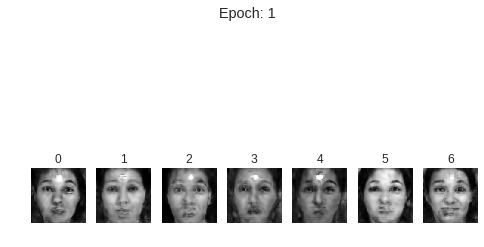

Epoch: 2/1000	Batch: 50/50	D_real_loss: 0.8742213249206543, D_generated_loss: 0.9639211297035217, G_loss: 0.6589677929878235
Epoch: 3/1000	Batch: 50/50	D_real_loss: 0.9717219471931458, D_generated_loss: 0.8772777915000916, G_loss: 0.7903750538825989
Epoch: 4/1000	Batch: 50/50	D_real_loss: 0.8402643203735352, D_generated_loss: 0.6715124249458313, G_loss: 0.7101478576660156
Epoch: 5/1000	Batch: 50/50	D_real_loss: 0.6983650326728821, D_generated_loss: 0.6949265599250793, G_loss: 0.9656329154968262
Epoch: 6/1000	Batch: 50/50	D_real_loss: 0.7189010977745056, D_generated_loss: 0.8008755445480347, G_loss: 0.6053518652915955
Epoch: 7/1000	Batch: 50/50	D_real_loss: 0.7581578493118286, D_generated_loss: 0.7625955939292908, G_loss: 0.7440928220748901
Epoch: 8/1000	Batch: 50/50	D_real_loss: 0.7352877855300903, D_generated_loss: 0.7575339078903198, G_loss: 0.7066398859024048
Epoch: 9/1000	Batch: 50/50	D_real_loss: 0.6962127089500427, D_generated_loss: 0.7828359603881836, G_loss: 0.6698276400566101


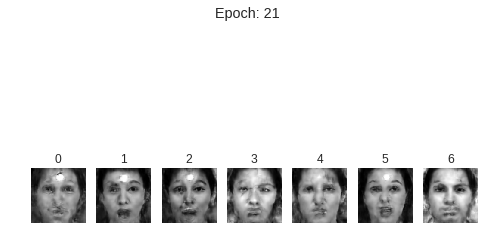

Epoch: 22/1000	Batch: 50/50	D_real_loss: 0.7075961232185364, D_generated_loss: 0.7114197611808777, G_loss: 0.7259711027145386
Epoch: 23/1000	Batch: 50/50	D_real_loss: 0.701693058013916, D_generated_loss: 0.7255092263221741, G_loss: 0.709882378578186
Epoch: 24/1000	Batch: 50/50	D_real_loss: 0.7103807330131531, D_generated_loss: 0.7233487963676453, G_loss: 0.7183460593223572
Epoch: 25/1000	Batch: 50/50	D_real_loss: 0.6337926983833313, D_generated_loss: 0.6822046637535095, G_loss: 0.7245239019393921
Epoch: 26/1000	Batch: 50/50	D_real_loss: 0.7361888885498047, D_generated_loss: 0.6944271326065063, G_loss: 0.6620669960975647
Epoch: 27/1000	Batch: 50/50	D_real_loss: 0.6823796033859253, D_generated_loss: 0.7231687903404236, G_loss: 0.6995223164558411
Epoch: 28/1000	Batch: 50/50	D_real_loss: 0.6800928115844727, D_generated_loss: 0.7151163816452026, G_loss: 0.6828075647354126
Epoch: 29/1000	Batch: 50/50	D_real_loss: 0.6812111735343933, D_generated_loss: 0.7193499803543091, G_loss: 0.74970978498

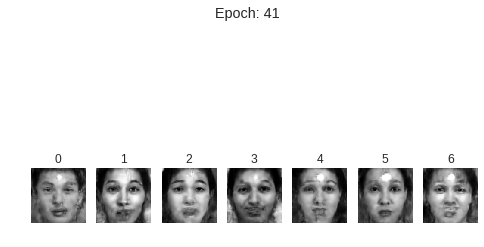

Epoch: 42/1000	Batch: 50/50	D_real_loss: 0.7337430119514465, D_generated_loss: 0.7089365720748901, G_loss: 0.6805207133293152
Epoch: 43/1000	Batch: 50/50	D_real_loss: 0.699193000793457, D_generated_loss: 0.7222264409065247, G_loss: 0.6819161772727966
Epoch: 44/1000	Batch: 50/50	D_real_loss: 0.7107038497924805, D_generated_loss: 0.762067437171936, G_loss: 0.6765156984329224
Epoch: 45/1000	Batch: 50/50	D_real_loss: 0.7105704545974731, D_generated_loss: 0.6563383936882019, G_loss: 0.7044469118118286
Epoch: 46/1000	Batch: 50/50	D_real_loss: 0.7027251124382019, D_generated_loss: 0.7354615330696106, G_loss: 0.7287042737007141
Epoch: 47/1000	Batch: 50/50	D_real_loss: 0.7135447859764099, D_generated_loss: 0.6907554864883423, G_loss: 0.6833824515342712
Epoch: 48/1000	Batch: 50/50	D_real_loss: 0.67805415391922, D_generated_loss: 0.7018556594848633, G_loss: 0.7404358983039856
Epoch: 49/1000	Batch: 50/50	D_real_loss: 0.6907323002815247, D_generated_loss: 0.709060788154602, G_loss: 0.65176773071289

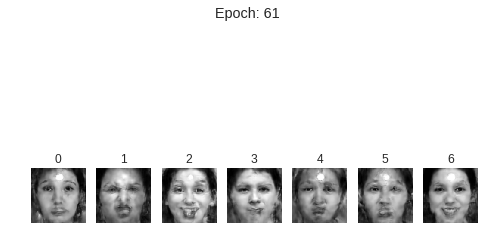

Epoch: 62/1000	Batch: 50/50	D_real_loss: 0.6873367428779602, D_generated_loss: 0.6635637283325195, G_loss: 0.7084962129592896
Epoch: 63/1000	Batch: 50/50	D_real_loss: 0.6844833493232727, D_generated_loss: 0.7243528366088867, G_loss: 0.7470433115959167
Epoch: 64/1000	Batch: 50/50	D_real_loss: 0.6804715394973755, D_generated_loss: 0.6819797158241272, G_loss: 0.7256122827529907
Epoch: 65/1000	Batch: 50/50	D_real_loss: 0.6604649424552917, D_generated_loss: 0.699687123298645, G_loss: 0.7148939967155457
Epoch: 66/1000	Batch: 50/50	D_real_loss: 0.6774749159812927, D_generated_loss: 0.6958886384963989, G_loss: 0.7021003365516663
Epoch: 67/1000	Batch: 50/50	D_real_loss: 0.6673997044563293, D_generated_loss: 0.7242096662521362, G_loss: 0.6483136415481567
Epoch: 68/1000	Batch: 50/50	D_real_loss: 0.6941998600959778, D_generated_loss: 0.720953643321991, G_loss: 0.7346596717834473
Epoch: 69/1000	Batch: 50/50	D_real_loss: 0.7158591151237488, D_generated_loss: 0.678644597530365, G_loss: 0.703460991382

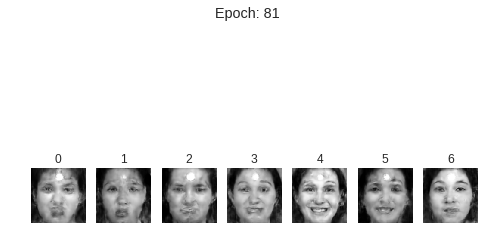

Epoch: 82/1000	Batch: 50/50	D_real_loss: 0.7133740186691284, D_generated_loss: 0.692492663860321, G_loss: 0.7168554067611694
Epoch: 83/1000	Batch: 50/50	D_real_loss: 0.6853671669960022, D_generated_loss: 0.7059078216552734, G_loss: 0.6852012276649475
Epoch: 84/1000	Batch: 50/50	D_real_loss: 0.724611759185791, D_generated_loss: 0.7326635718345642, G_loss: 0.69682776927948
Epoch: 85/1000	Batch: 50/50	D_real_loss: 0.6790129542350769, D_generated_loss: 0.6850004196166992, G_loss: 0.6728440523147583
Epoch: 86/1000	Batch: 50/50	D_real_loss: 0.6927371621131897, D_generated_loss: 0.6867213845252991, G_loss: 0.6362277269363403
Epoch: 87/1000	Batch: 50/50	D_real_loss: 0.6744304895401001, D_generated_loss: 0.7112125158309937, G_loss: 0.7145351767539978
Epoch: 88/1000	Batch: 50/50	D_real_loss: 0.7142180800437927, D_generated_loss: 0.6787880659103394, G_loss: 0.6760296821594238
Epoch: 89/1000	Batch: 50/50	D_real_loss: 0.7027145028114319, D_generated_loss: 0.6749907732009888, G_loss: 0.7120172381401

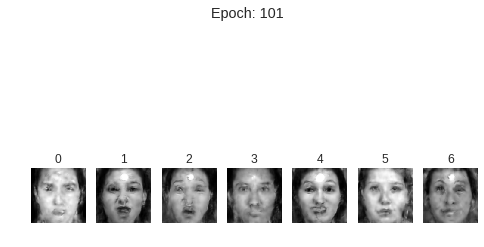

Epoch: 102/1000	Batch: 50/50	D_real_loss: 0.6655529141426086, D_generated_loss: 0.6866276860237122, G_loss: 0.7106673121452332
Epoch: 103/1000	Batch: 50/50	D_real_loss: 0.6770967841148376, D_generated_loss: 0.6890000104904175, G_loss: 0.6676129102706909
Epoch: 104/1000	Batch: 50/50	D_real_loss: 0.6910757422447205, D_generated_loss: 0.6864889860153198, G_loss: 0.7045604586601257
Epoch: 105/1000	Batch: 50/50	D_real_loss: 0.6958168745040894, D_generated_loss: 0.6607146263122559, G_loss: 0.6736351251602173
Epoch: 106/1000	Batch: 50/50	D_real_loss: 0.6926469802856445, D_generated_loss: 0.6893536448478699, G_loss: 0.6885297894477844
Epoch: 107/1000	Batch: 50/50	D_real_loss: 0.664638102054596, D_generated_loss: 0.6833083033561707, G_loss: 0.6807926893234253
Epoch: 108/1000	Batch: 50/50	D_real_loss: 0.7114924788475037, D_generated_loss: 0.6841357350349426, G_loss: 0.6987780928611755
Epoch: 109/1000	Batch: 50/50	D_real_loss: 0.7018885016441345, D_generated_loss: 0.7191384434700012, G_loss: 0.72

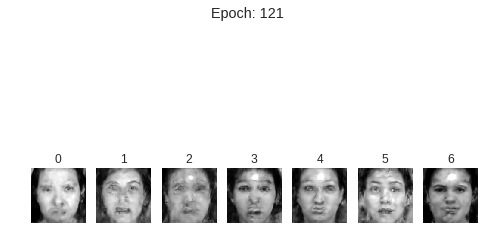

Epoch: 122/1000	Batch: 50/50	D_real_loss: 0.7276389002799988, D_generated_loss: 0.7022587656974792, G_loss: 0.7402061223983765
Epoch: 123/1000	Batch: 50/50	D_real_loss: 0.6853693723678589, D_generated_loss: 0.7456310391426086, G_loss: 0.6944451928138733
Epoch: 124/1000	Batch: 50/50	D_real_loss: 0.6953192949295044, D_generated_loss: 0.7094763517379761, G_loss: 0.6701807975769043
Epoch: 125/1000	Batch: 50/50	D_real_loss: 0.6869354248046875, D_generated_loss: 0.6866996884346008, G_loss: 0.7035485506057739
Epoch: 126/1000	Batch: 50/50	D_real_loss: 0.7212887406349182, D_generated_loss: 0.6904258131980896, G_loss: 0.6946121454238892
Epoch: 127/1000	Batch: 50/50	D_real_loss: 0.7105475068092346, D_generated_loss: 0.6882839202880859, G_loss: 0.6473830938339233
Epoch: 128/1000	Batch: 50/50	D_real_loss: 0.7101636528968811, D_generated_loss: 0.6914021372795105, G_loss: 0.7136643528938293
Epoch: 129/1000	Batch: 50/50	D_real_loss: 0.673710823059082, D_generated_loss: 0.6848929524421692, G_loss: 0.68

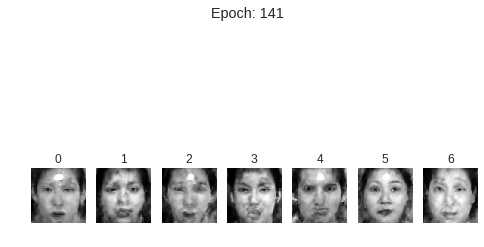

Epoch: 142/1000	Batch: 50/50	D_real_loss: 0.7022090554237366, D_generated_loss: 0.6923456192016602, G_loss: 0.702495276927948
Epoch: 143/1000	Batch: 50/50	D_real_loss: 0.718971848487854, D_generated_loss: 0.7220066785812378, G_loss: 0.7057751417160034
Epoch: 144/1000	Batch: 50/50	D_real_loss: 0.7122906446456909, D_generated_loss: 0.6849570870399475, G_loss: 0.7080861330032349
Epoch: 145/1000	Batch: 50/50	D_real_loss: 0.7056838870048523, D_generated_loss: 0.711681067943573, G_loss: 0.6811203956604004
Epoch: 146/1000	Batch: 50/50	D_real_loss: 0.6852949857711792, D_generated_loss: 0.7108003497123718, G_loss: 0.6985588073730469
Epoch: 147/1000	Batch: 50/50	D_real_loss: 0.6821907758712769, D_generated_loss: 0.7017955780029297, G_loss: 0.6943875551223755
Epoch: 148/1000	Batch: 50/50	D_real_loss: 0.707365870475769, D_generated_loss: 0.7143220901489258, G_loss: 0.6870658993721008
Epoch: 149/1000	Batch: 50/50	D_real_loss: 0.7081602811813354, D_generated_loss: 0.6756994128227234, G_loss: 0.67942

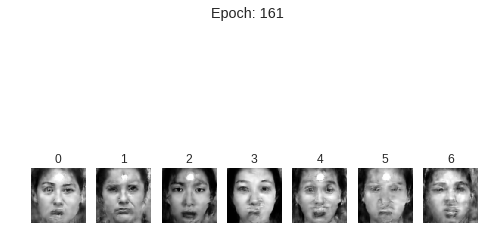

Epoch: 162/1000	Batch: 50/50	D_real_loss: 0.7091573476791382, D_generated_loss: 0.7009631991386414, G_loss: 0.6936745047569275
Epoch: 163/1000	Batch: 50/50	D_real_loss: 0.6982459425926208, D_generated_loss: 0.7014191746711731, G_loss: 0.7158673405647278
Epoch: 164/1000	Batch: 50/50	D_real_loss: 0.703020453453064, D_generated_loss: 0.7118722200393677, G_loss: 0.7055646181106567
Epoch: 165/1000	Batch: 50/50	D_real_loss: 0.6850451231002808, D_generated_loss: 0.690699577331543, G_loss: 0.6989224553108215
Epoch: 166/1000	Batch: 50/50	D_real_loss: 0.7052348256111145, D_generated_loss: 0.6819371581077576, G_loss: 0.6989204287528992
Epoch: 167/1000	Batch: 50/50	D_real_loss: 0.7183433175086975, D_generated_loss: 0.7232888340950012, G_loss: 0.6921882033348083
Epoch: 168/1000	Batch: 50/50	D_real_loss: 0.7032860517501831, D_generated_loss: 0.6988843083381653, G_loss: 0.6552245020866394
Epoch: 169/1000	Batch: 50/50	D_real_loss: 0.6892045140266418, D_generated_loss: 0.7315491437911987, G_loss: 0.691

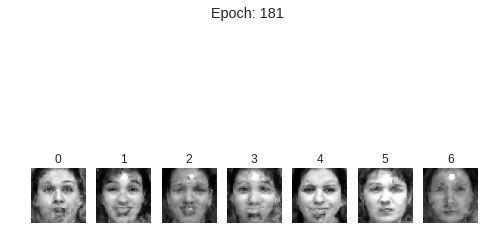

Epoch: 182/1000	Batch: 50/50	D_real_loss: 0.7015549540519714, D_generated_loss: 0.6848025918006897, G_loss: 0.7023736238479614
Epoch: 183/1000	Batch: 50/50	D_real_loss: 0.6933344602584839, D_generated_loss: 0.6755324602127075, G_loss: 0.6759627461433411
Epoch: 184/1000	Batch: 50/50	D_real_loss: 0.6733863949775696, D_generated_loss: 0.6916965246200562, G_loss: 0.6895367503166199
Epoch: 185/1000	Batch: 50/50	D_real_loss: 0.6674305200576782, D_generated_loss: 0.6798836588859558, G_loss: 0.6845760345458984
Epoch: 186/1000	Batch: 50/50	D_real_loss: 0.7139477133750916, D_generated_loss: 0.7129248976707458, G_loss: 0.6684570908546448
Epoch: 187/1000	Batch: 50/50	D_real_loss: 0.7078036069869995, D_generated_loss: 0.6924792528152466, G_loss: 0.6493043899536133
Epoch: 188/1000	Batch: 50/50	D_real_loss: 0.6849237680435181, D_generated_loss: 0.7046005129814148, G_loss: 0.7157145738601685
Epoch: 189/1000	Batch: 50/50	D_real_loss: 0.709570586681366, D_generated_loss: 0.7137719392776489, G_loss: 0.71

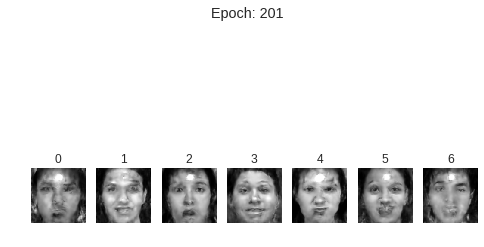

Epoch: 202/1000	Batch: 50/50	D_real_loss: 0.6911339163780212, D_generated_loss: 0.6951935887336731, G_loss: 0.7475489377975464
Epoch: 203/1000	Batch: 50/50	D_real_loss: 0.6775445938110352, D_generated_loss: 0.6943413615226746, G_loss: 0.7042790055274963
Epoch: 204/1000	Batch: 50/50	D_real_loss: 0.6997395157814026, D_generated_loss: 0.7374884486198425, G_loss: 0.6879429221153259
Epoch: 205/1000	Batch: 50/50	D_real_loss: 0.6931389570236206, D_generated_loss: 0.700058102607727, G_loss: 0.6851822137832642
Epoch: 206/1000	Batch: 50/50	D_real_loss: 0.703508734703064, D_generated_loss: 0.7167149782180786, G_loss: 0.6866031289100647
Epoch: 207/1000	Batch: 50/50	D_real_loss: 0.7212485074996948, D_generated_loss: 0.723199188709259, G_loss: 0.6947625875473022
Epoch: 208/1000	Batch: 50/50	D_real_loss: 0.676447868347168, D_generated_loss: 0.6937971115112305, G_loss: 0.7005513906478882
Epoch: 209/1000	Batch: 50/50	D_real_loss: 0.6799138188362122, D_generated_loss: 0.70228511095047, G_loss: 0.6857618

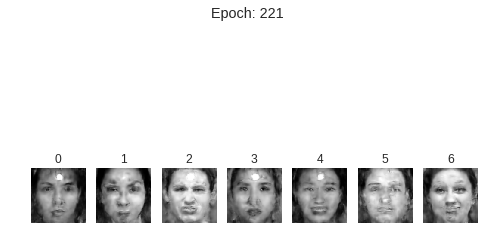

Epoch: 222/1000	Batch: 50/50	D_real_loss: 0.6735649704933167, D_generated_loss: 0.6589986085891724, G_loss: 0.698384702205658
Epoch: 223/1000	Batch: 50/50	D_real_loss: 0.6660324335098267, D_generated_loss: 0.7211537957191467, G_loss: 0.6946948170661926
Epoch: 224/1000	Batch: 50/50	D_real_loss: 0.706410825252533, D_generated_loss: 0.683049201965332, G_loss: 0.736694872379303
Epoch: 225/1000	Batch: 50/50	D_real_loss: 0.69129478931427, D_generated_loss: 0.680202841758728, G_loss: 0.6976780295372009
Epoch: 226/1000	Batch: 50/50	D_real_loss: 0.7111252546310425, D_generated_loss: 0.7031153440475464, G_loss: 0.6894159317016602
Epoch: 227/1000	Batch: 50/50	D_real_loss: 0.6888741254806519, D_generated_loss: 0.6931870579719543, G_loss: 0.6972894668579102
Epoch: 228/1000	Batch: 50/50	D_real_loss: 0.6964756846427917, D_generated_loss: 0.6679221391677856, G_loss: 0.6859039664268494
Epoch: 229/1000	Batch: 50/50	D_real_loss: 0.6765056848526001, D_generated_loss: 0.6924214959144592, G_loss: 0.68455022

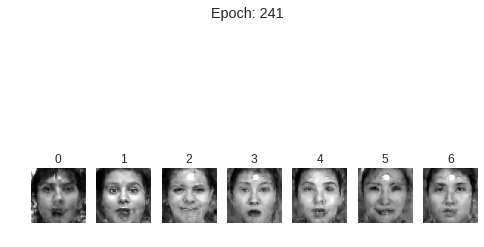

Epoch: 242/1000	Batch: 50/50	D_real_loss: 0.7066187858581543, D_generated_loss: 0.713301956653595, G_loss: 0.6849384903907776
Epoch: 243/1000	Batch: 50/50	D_real_loss: 0.6852448582649231, D_generated_loss: 0.6924881339073181, G_loss: 0.6889634132385254
Epoch: 244/1000	Batch: 50/50	D_real_loss: 0.6778449416160583, D_generated_loss: 0.6604153513908386, G_loss: 0.6752222776412964
Epoch: 245/1000	Batch: 50/50	D_real_loss: 0.6851414442062378, D_generated_loss: 0.6727165579795837, G_loss: 0.6999207735061646
Epoch: 246/1000	Batch: 50/50	D_real_loss: 0.7212260365486145, D_generated_loss: 0.6978150010108948, G_loss: 0.6725269556045532
Epoch: 247/1000	Batch: 50/50	D_real_loss: 0.7041818499565125, D_generated_loss: 0.6869411468505859, G_loss: 0.7210916876792908
Epoch: 248/1000	Batch: 50/50	D_real_loss: 0.6875160932540894, D_generated_loss: 0.6778527498245239, G_loss: 0.6704816222190857
Epoch: 249/1000	Batch: 50/50	D_real_loss: 0.7082206010818481, D_generated_loss: 0.7224587798118591, G_loss: 0.69

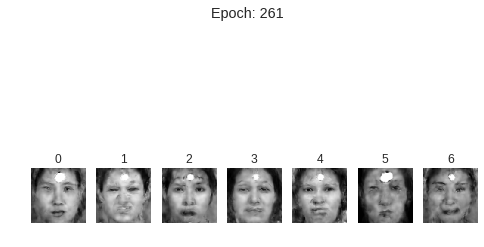

Epoch: 262/1000	Batch: 50/50	D_real_loss: 0.6939536929130554, D_generated_loss: 0.7365460991859436, G_loss: 0.7033337354660034
Epoch: 263/1000	Batch: 50/50	D_real_loss: 0.6939347386360168, D_generated_loss: 0.6793027520179749, G_loss: 0.6789120435714722
Epoch: 264/1000	Batch: 50/50	D_real_loss: 0.6916934251785278, D_generated_loss: 0.6929918527603149, G_loss: 0.6947809457778931
Epoch: 265/1000	Batch: 50/50	D_real_loss: 0.6876363754272461, D_generated_loss: 0.7299819588661194, G_loss: 0.7202144265174866
Epoch: 266/1000	Batch: 50/50	D_real_loss: 0.6766724586486816, D_generated_loss: 0.673909604549408, G_loss: 0.6908644437789917
Epoch: 267/1000	Batch: 50/50	D_real_loss: 0.7075619101524353, D_generated_loss: 0.6916335225105286, G_loss: 0.700302004814148
Epoch: 268/1000	Batch: 50/50	D_real_loss: 0.6975863575935364, D_generated_loss: 0.6933325529098511, G_loss: 0.6780303120613098
Epoch: 269/1000	Batch: 50/50	D_real_loss: 0.7412176132202148, D_generated_loss: 0.7149308323860168, G_loss: 0.708

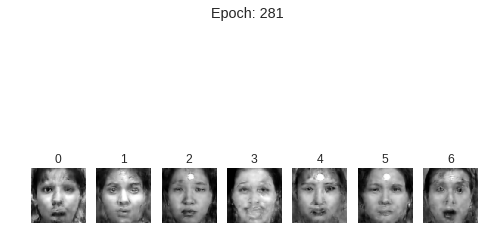

Epoch: 282/1000	Batch: 50/50	D_real_loss: 0.6915908455848694, D_generated_loss: 0.6894050240516663, G_loss: 0.6892040967941284
Epoch: 283/1000	Batch: 50/50	D_real_loss: 0.6843801140785217, D_generated_loss: 0.707421600818634, G_loss: 0.6938560605049133
Epoch: 284/1000	Batch: 50/50	D_real_loss: 0.7101267576217651, D_generated_loss: 0.704557478427887, G_loss: 0.6898651123046875
Epoch: 285/1000	Batch: 50/50	D_real_loss: 0.6974586844444275, D_generated_loss: 0.6776179671287537, G_loss: 0.6781124472618103
Epoch: 286/1000	Batch: 50/50	D_real_loss: 0.6952716112136841, D_generated_loss: 0.6933490037918091, G_loss: 0.6818947196006775
Epoch: 287/1000	Batch: 50/50	D_real_loss: 0.6993943452835083, D_generated_loss: 0.7059544324874878, G_loss: 0.7185810804367065
Epoch: 288/1000	Batch: 50/50	D_real_loss: 0.6884397864341736, D_generated_loss: 0.701206386089325, G_loss: 0.6788732409477234
Epoch: 289/1000	Batch: 50/50	D_real_loss: 0.7116661071777344, D_generated_loss: 0.7159972786903381, G_loss: 0.7119

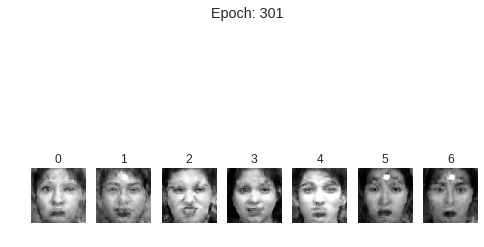

Epoch: 302/1000	Batch: 50/50	D_real_loss: 0.6960844397544861, D_generated_loss: 0.7139437794685364, G_loss: 0.6955785751342773
Epoch: 303/1000	Batch: 50/50	D_real_loss: 0.6801711320877075, D_generated_loss: 0.7053599953651428, G_loss: 0.6820893287658691
Epoch: 304/1000	Batch: 50/50	D_real_loss: 0.6759417653083801, D_generated_loss: 0.690546452999115, G_loss: 0.693410336971283
Epoch: 305/1000	Batch: 50/50	D_real_loss: 0.7134313583374023, D_generated_loss: 0.6900483965873718, G_loss: 0.6983851194381714
Epoch: 306/1000	Batch: 50/50	D_real_loss: 0.6819673180580139, D_generated_loss: 0.7102536559104919, G_loss: 0.6895266771316528
Epoch: 307/1000	Batch: 50/50	D_real_loss: 0.6959745287895203, D_generated_loss: 0.684824526309967, G_loss: 0.6993830800056458
Epoch: 308/1000	Batch: 50/50	D_real_loss: 0.6932995915412903, D_generated_loss: 0.7045016884803772, G_loss: 0.6815536618232727
Epoch: 309/1000	Batch: 50/50	D_real_loss: 0.6861099600791931, D_generated_loss: 0.6801315546035767, G_loss: 0.6832

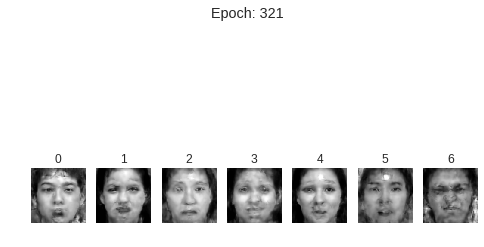

Epoch: 322/1000	Batch: 50/50	D_real_loss: 0.6905856728553772, D_generated_loss: 0.6818194389343262, G_loss: 0.6964925527572632
Epoch: 323/1000	Batch: 50/50	D_real_loss: 0.7063652873039246, D_generated_loss: 0.7088888883590698, G_loss: 0.6907504796981812
Epoch: 324/1000	Batch: 50/50	D_real_loss: 0.707821249961853, D_generated_loss: 0.6980857849121094, G_loss: 0.6934760808944702
Epoch: 325/1000	Batch: 50/50	D_real_loss: 0.6853532791137695, D_generated_loss: 0.7106930613517761, G_loss: 0.6874055862426758
Epoch: 326/1000	Batch: 50/50	D_real_loss: 0.6981633901596069, D_generated_loss: 0.7014051675796509, G_loss: 0.6780346632003784
Epoch: 327/1000	Batch: 50/50	D_real_loss: 0.6931939721107483, D_generated_loss: 0.6776575446128845, G_loss: 0.6896682381629944
Epoch: 328/1000	Batch: 50/50	D_real_loss: 0.6715013384819031, D_generated_loss: 0.7188579440116882, G_loss: 0.6875222325325012
Epoch: 329/1000	Batch: 50/50	D_real_loss: 0.6997681856155396, D_generated_loss: 0.7026773691177368, G_loss: 0.68

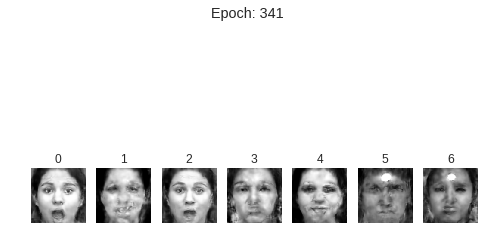

Epoch: 342/1000	Batch: 50/50	D_real_loss: 0.7016230225563049, D_generated_loss: 0.6836381554603577, G_loss: 0.6936812400817871
Epoch: 343/1000	Batch: 50/50	D_real_loss: 0.722176194190979, D_generated_loss: 0.6957801580429077, G_loss: 0.6954041123390198
Epoch: 344/1000	Batch: 50/50	D_real_loss: 0.6941328048706055, D_generated_loss: 0.6867260336875916, G_loss: 0.6849011182785034
Epoch: 345/1000	Batch: 50/50	D_real_loss: 0.6750691533088684, D_generated_loss: 0.7015639543533325, G_loss: 0.6948410868644714
Epoch: 346/1000	Batch: 50/50	D_real_loss: 0.7027594447135925, D_generated_loss: 0.6792846322059631, G_loss: 0.6982066035270691
Epoch: 347/1000	Batch: 50/50	D_real_loss: 0.685240626335144, D_generated_loss: 0.6866815686225891, G_loss: 0.679169237613678
Epoch: 348/1000	Batch: 50/50	D_real_loss: 0.6930076479911804, D_generated_loss: 0.6972556710243225, G_loss: 0.6836305260658264
Epoch: 349/1000	Batch: 50/50	D_real_loss: 0.698562741279602, D_generated_loss: 0.6995973587036133, G_loss: 0.69033

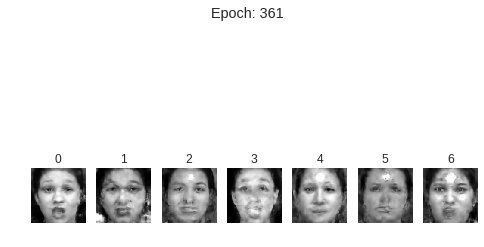

Epoch: 362/1000	Batch: 50/50	D_real_loss: 0.6957491636276245, D_generated_loss: 0.6783372759819031, G_loss: 0.6910462975502014
Epoch: 363/1000	Batch: 50/50	D_real_loss: 0.6905789971351624, D_generated_loss: 0.6943109631538391, G_loss: 0.6886721849441528
Epoch: 364/1000	Batch: 50/50	D_real_loss: 0.7119845747947693, D_generated_loss: 0.6938014626502991, G_loss: 0.723685622215271
Epoch: 365/1000	Batch: 50/50	D_real_loss: 0.7059263586997986, D_generated_loss: 0.6980224251747131, G_loss: 0.679280698299408
Epoch: 366/1000	Batch: 50/50	D_real_loss: 0.6978583931922913, D_generated_loss: 0.704908013343811, G_loss: 0.6961859464645386
Epoch: 367/1000	Batch: 50/50	D_real_loss: 0.6780144572257996, D_generated_loss: 0.6867251396179199, G_loss: 0.6983193159103394
Epoch: 368/1000	Batch: 50/50	D_real_loss: 0.6939254999160767, D_generated_loss: 0.6920595169067383, G_loss: 0.6937907338142395
Epoch: 369/1000	Batch: 50/50	D_real_loss: 0.6781527400016785, D_generated_loss: 0.703170895576477, G_loss: 0.69229

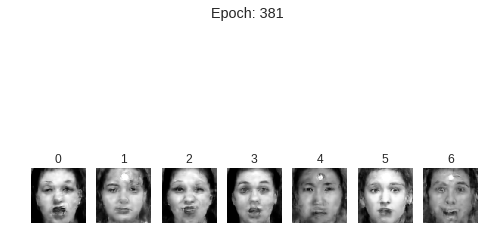

Epoch: 382/1000	Batch: 50/50	D_real_loss: 0.6820601224899292, D_generated_loss: 0.7038764953613281, G_loss: 0.7037296891212463
Epoch: 383/1000	Batch: 50/50	D_real_loss: 0.6858753561973572, D_generated_loss: 0.6946035027503967, G_loss: 0.6937856674194336
Epoch: 384/1000	Batch: 50/50	D_real_loss: 0.708572268486023, D_generated_loss: 0.7048758268356323, G_loss: 0.6846357583999634
Epoch: 385/1000	Batch: 50/50	D_real_loss: 0.6996532082557678, D_generated_loss: 0.7001480460166931, G_loss: 0.6915270686149597
Epoch: 386/1000	Batch: 50/50	D_real_loss: 0.6872227787971497, D_generated_loss: 0.6993149518966675, G_loss: 0.69660484790802
Epoch: 387/1000	Batch: 50/50	D_real_loss: 0.6883673071861267, D_generated_loss: 0.6956679224967957, G_loss: 0.6847633719444275
Epoch: 388/1000	Batch: 50/50	D_real_loss: 0.7014517188072205, D_generated_loss: 0.6935914158821106, G_loss: 0.690128743648529
Epoch: 389/1000	Batch: 50/50	D_real_loss: 0.675390899181366, D_generated_loss: 0.7060629725456238, G_loss: 0.676741

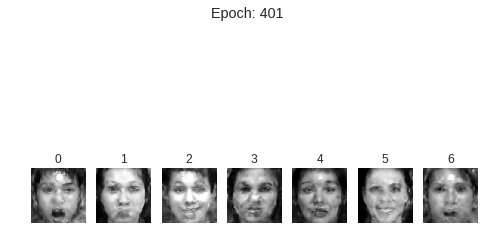

Epoch: 402/1000	Batch: 50/50	D_real_loss: 0.697236180305481, D_generated_loss: 0.7000461220741272, G_loss: 0.7016162872314453
Epoch: 403/1000	Batch: 50/50	D_real_loss: 0.7103525996208191, D_generated_loss: 0.7070993185043335, G_loss: 0.700988233089447
Epoch: 404/1000	Batch: 50/50	D_real_loss: 0.7072097659111023, D_generated_loss: 0.7010372281074524, G_loss: 0.6975685954093933
Epoch: 405/1000	Batch: 50/50	D_real_loss: 0.6920666098594666, D_generated_loss: 0.6868547201156616, G_loss: 0.6898791193962097
Epoch: 406/1000	Batch: 50/50	D_real_loss: 0.689494788646698, D_generated_loss: 0.6965748071670532, G_loss: 0.6949360966682434
Epoch: 407/1000	Batch: 50/50	D_real_loss: 0.7144298553466797, D_generated_loss: 0.6932677626609802, G_loss: 0.6835098266601562
Epoch: 408/1000	Batch: 50/50	D_real_loss: 0.696777880191803, D_generated_loss: 0.7130109071731567, G_loss: 0.6963453888893127
Epoch: 409/1000	Batch: 50/50	D_real_loss: 0.6963958740234375, D_generated_loss: 0.6886148452758789, G_loss: 0.70021

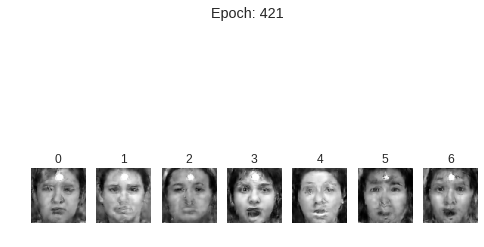

Epoch: 422/1000	Batch: 50/50	D_real_loss: 0.6903309226036072, D_generated_loss: 0.6879218816757202, G_loss: 0.7010784149169922
Epoch: 423/1000	Batch: 50/50	D_real_loss: 0.6959081292152405, D_generated_loss: 0.6981047987937927, G_loss: 0.6771782040596008
Epoch: 424/1000	Batch: 50/50	D_real_loss: 0.7120088934898376, D_generated_loss: 0.7023118138313293, G_loss: 0.6832433342933655
Epoch: 425/1000	Batch: 50/50	D_real_loss: 0.6987594962120056, D_generated_loss: 0.6973908543586731, G_loss: 0.6818493008613586
Epoch: 426/1000	Batch: 50/50	D_real_loss: 0.6991838812828064, D_generated_loss: 0.6828049421310425, G_loss: 0.6965335607528687
Epoch: 427/1000	Batch: 50/50	D_real_loss: 0.6961654424667358, D_generated_loss: 0.6823106408119202, G_loss: 0.7143405079841614
Epoch: 428/1000	Batch: 50/50	D_real_loss: 0.6913255453109741, D_generated_loss: 0.6834254264831543, G_loss: 0.7125670313835144
Epoch: 429/1000	Batch: 50/50	D_real_loss: 0.6757170557975769, D_generated_loss: 0.6995862126350403, G_loss: 0.6

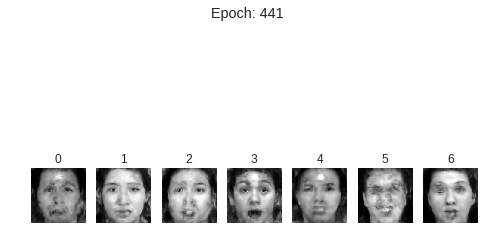

Epoch: 442/1000	Batch: 50/50	D_real_loss: 0.6999644041061401, D_generated_loss: 0.6871720552444458, G_loss: 0.7016410827636719
Epoch: 443/1000	Batch: 50/50	D_real_loss: 0.6879445910453796, D_generated_loss: 0.6828377842903137, G_loss: 0.7012515664100647
Epoch: 444/1000	Batch: 50/50	D_real_loss: 0.6952279210090637, D_generated_loss: 0.6854033470153809, G_loss: 0.6913483738899231
Epoch: 445/1000	Batch: 50/50	D_real_loss: 0.6886983513832092, D_generated_loss: 0.6794438362121582, G_loss: 0.6776356101036072
Epoch: 446/1000	Batch: 50/50	D_real_loss: 0.7088823318481445, D_generated_loss: 0.6987982988357544, G_loss: 0.6929531693458557
Epoch: 447/1000	Batch: 50/50	D_real_loss: 0.7002164721488953, D_generated_loss: 0.6936610341072083, G_loss: 0.6850982904434204
Epoch: 448/1000	Batch: 50/50	D_real_loss: 0.6884406805038452, D_generated_loss: 0.7072089314460754, G_loss: 0.6949753165245056
Epoch: 449/1000	Batch: 50/50	D_real_loss: 0.6978073716163635, D_generated_loss: 0.6910586953163147, G_loss: 0.6

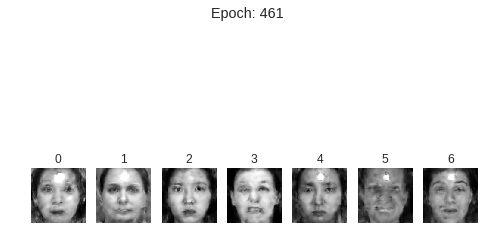

Epoch: 462/1000	Batch: 50/50	D_real_loss: 0.6991650462150574, D_generated_loss: 0.6867346167564392, G_loss: 0.6928480863571167
Epoch: 463/1000	Batch: 50/50	D_real_loss: 0.6937599182128906, D_generated_loss: 0.6863321661949158, G_loss: 0.7096748948097229
Epoch: 464/1000	Batch: 50/50	D_real_loss: 0.6953175663948059, D_generated_loss: 0.6894294023513794, G_loss: 0.6921494603157043
Epoch: 465/1000	Batch: 50/50	D_real_loss: 0.693363606929779, D_generated_loss: 0.690856397151947, G_loss: 0.6885084509849548
Epoch: 466/1000	Batch: 50/50	D_real_loss: 0.698089063167572, D_generated_loss: 0.7125324010848999, G_loss: 0.6886460185050964
Epoch: 467/1000	Batch: 50/50	D_real_loss: 0.6956015825271606, D_generated_loss: 0.6864733099937439, G_loss: 0.6940504908561707
Epoch: 468/1000	Batch: 50/50	D_real_loss: 0.6983626484870911, D_generated_loss: 0.6803639531135559, G_loss: 0.6844784617424011
Epoch: 469/1000	Batch: 50/50	D_real_loss: 0.696797251701355, D_generated_loss: 0.6863169074058533, G_loss: 0.69596

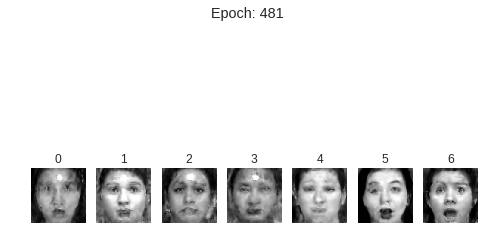

Epoch: 482/1000	Batch: 50/50	D_real_loss: 0.6947354078292847, D_generated_loss: 0.68576580286026, G_loss: 0.7019602656364441
Epoch: 483/1000	Batch: 50/50	D_real_loss: 0.6908341646194458, D_generated_loss: 0.695364773273468, G_loss: 0.6931325793266296
Epoch: 484/1000	Batch: 50/50	D_real_loss: 0.7046307325363159, D_generated_loss: 0.6926204562187195, G_loss: 0.6967701315879822
Epoch: 485/1000	Batch: 50/50	D_real_loss: 0.6919441819190979, D_generated_loss: 0.6924166083335876, G_loss: 0.6922047734260559
Epoch: 486/1000	Batch: 50/50	D_real_loss: 0.6985033750534058, D_generated_loss: 0.6901306509971619, G_loss: 0.6930014491081238
Epoch: 487/1000	Batch: 50/50	D_real_loss: 0.6980794072151184, D_generated_loss: 0.6908715963363647, G_loss: 0.6957231760025024
Epoch: 488/1000	Batch: 50/50	D_real_loss: 0.6910586357116699, D_generated_loss: 0.7116837501525879, G_loss: 0.6975641846656799
Epoch: 489/1000	Batch: 50/50	D_real_loss: 0.6906675100326538, D_generated_loss: 0.7008618712425232, G_loss: 0.6955

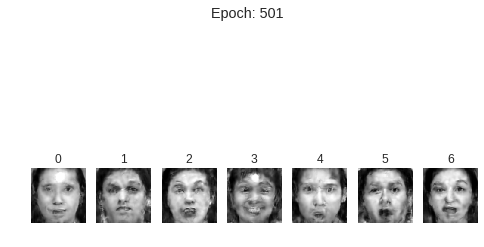

Epoch: 502/1000	Batch: 50/50	D_real_loss: 0.7071970701217651, D_generated_loss: 0.6977323889732361, G_loss: 0.6886500120162964
Epoch: 503/1000	Batch: 50/50	D_real_loss: 0.683161735534668, D_generated_loss: 0.6947759389877319, G_loss: 0.6981315016746521
Epoch: 504/1000	Batch: 50/50	D_real_loss: 0.7000033259391785, D_generated_loss: 0.6979338526725769, G_loss: 0.7014894485473633
Epoch: 505/1000	Batch: 50/50	D_real_loss: 0.7029717564582825, D_generated_loss: 0.6848589181900024, G_loss: 0.6987214088439941
Epoch: 506/1000	Batch: 50/50	D_real_loss: 0.687494695186615, D_generated_loss: 0.6823868155479431, G_loss: 0.6968532800674438
Epoch: 507/1000	Batch: 50/50	D_real_loss: 0.7007609009742737, D_generated_loss: 0.6943318247795105, G_loss: 0.6883715391159058
Epoch: 508/1000	Batch: 50/50	D_real_loss: 0.6965179443359375, D_generated_loss: 0.6918641924858093, G_loss: 0.7016841769218445
Epoch: 509/1000	Batch: 50/50	D_real_loss: 0.7072401642799377, D_generated_loss: 0.6967453956604004, G_loss: 0.691

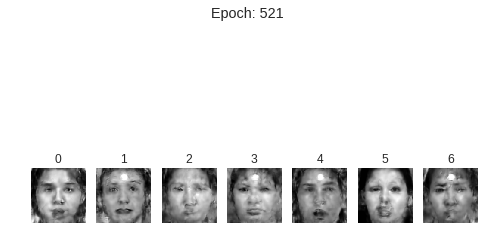

Epoch: 522/1000	Batch: 50/50	D_real_loss: 0.6898933053016663, D_generated_loss: 0.6892004609107971, G_loss: 0.6914727091789246
Epoch: 523/1000	Batch: 50/50	D_real_loss: 0.6908011436462402, D_generated_loss: 0.6949309706687927, G_loss: 0.6966883540153503
Epoch: 524/1000	Batch: 50/50	D_real_loss: 0.6875645518302917, D_generated_loss: 0.6920300126075745, G_loss: 0.6941247582435608
Epoch: 525/1000	Batch: 50/50	D_real_loss: 0.6896904706954956, D_generated_loss: 0.6880039572715759, G_loss: 0.6826860308647156
Epoch: 526/1000	Batch: 50/50	D_real_loss: 0.7027363181114197, D_generated_loss: 0.6916905045509338, G_loss: 0.6945244669914246
Epoch: 527/1000	Batch: 50/50	D_real_loss: 0.6995519995689392, D_generated_loss: 0.6936091184616089, G_loss: 0.6894612908363342
Epoch: 528/1000	Batch: 50/50	D_real_loss: 0.6946185231208801, D_generated_loss: 0.690433919429779, G_loss: 0.6984652280807495
Epoch: 529/1000	Batch: 50/50	D_real_loss: 0.708293080329895, D_generated_loss: 0.6882234215736389, G_loss: 0.702

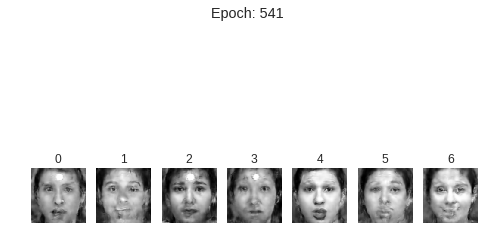

Epoch: 542/1000	Batch: 50/50	D_real_loss: 0.6903282999992371, D_generated_loss: 0.691625714302063, G_loss: 0.6982247233390808
Epoch: 543/1000	Batch: 50/50	D_real_loss: 0.6850054860115051, D_generated_loss: 0.7000126242637634, G_loss: 0.6925393342971802
Epoch: 544/1000	Batch: 50/50	D_real_loss: 0.7043618559837341, D_generated_loss: 0.6971426010131836, G_loss: 0.693842887878418
Epoch: 545/1000	Batch: 50/50	D_real_loss: 0.6931895017623901, D_generated_loss: 0.6964377760887146, G_loss: 0.6948396563529968
Epoch: 546/1000	Batch: 50/50	D_real_loss: 0.6953469514846802, D_generated_loss: 0.6956450343132019, G_loss: 0.6879875063896179
Epoch: 547/1000	Batch: 50/50	D_real_loss: 0.7049261927604675, D_generated_loss: 0.6918964385986328, G_loss: 0.7059733271598816
Epoch: 548/1000	Batch: 50/50	D_real_loss: 0.6879259943962097, D_generated_loss: 0.7015671133995056, G_loss: 0.7006404995918274
Epoch: 549/1000	Batch: 50/50	D_real_loss: 0.6817558407783508, D_generated_loss: 0.6961814761161804, G_loss: 0.691

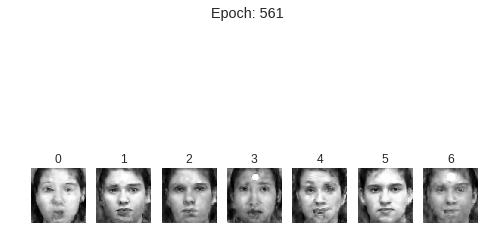

Epoch: 562/1000	Batch: 50/50	D_real_loss: 0.6974096894264221, D_generated_loss: 0.695403516292572, G_loss: 0.6906893849372864
Epoch: 563/1000	Batch: 50/50	D_real_loss: 0.6860450506210327, D_generated_loss: 0.6944882273674011, G_loss: 0.699555516242981
Epoch: 564/1000	Batch: 50/50	D_real_loss: 0.6924495100975037, D_generated_loss: 0.6864128112792969, G_loss: 0.7003342509269714
Epoch: 565/1000	Batch: 50/50	D_real_loss: 0.6979762315750122, D_generated_loss: 0.6974950432777405, G_loss: 0.6860427856445312
Epoch: 566/1000	Batch: 50/50	D_real_loss: 0.6988945007324219, D_generated_loss: 0.7015475034713745, G_loss: 0.6870041489601135
Epoch: 567/1000	Batch: 50/50	D_real_loss: 0.6928291320800781, D_generated_loss: 0.6888383626937866, G_loss: 0.690759539604187
Epoch: 568/1000	Batch: 50/50	D_real_loss: 0.6934528350830078, D_generated_loss: 0.6966231465339661, G_loss: 0.6922192573547363
Epoch: 569/1000	Batch: 50/50	D_real_loss: 0.6915885210037231, D_generated_loss: 0.6948009133338928, G_loss: 0.6995

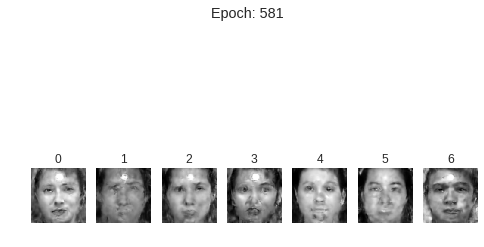

Epoch: 582/1000	Batch: 50/50	D_real_loss: 0.6996661424636841, D_generated_loss: 0.6834627985954285, G_loss: 0.6942618489265442
Epoch: 583/1000	Batch: 50/50	D_real_loss: 0.6966468095779419, D_generated_loss: 0.6867477297782898, G_loss: 0.6886261701583862
Epoch: 584/1000	Batch: 50/50	D_real_loss: 0.691040575504303, D_generated_loss: 0.6878790259361267, G_loss: 0.6936284303665161
Epoch: 585/1000	Batch: 50/50	D_real_loss: 0.6942678093910217, D_generated_loss: 0.6922354102134705, G_loss: 0.6995310187339783
Epoch: 586/1000	Batch: 50/50	D_real_loss: 0.683007538318634, D_generated_loss: 0.6947606205940247, G_loss: 0.7085222601890564
Epoch: 587/1000	Batch: 50/50	D_real_loss: 0.6927905678749084, D_generated_loss: 0.7003631591796875, G_loss: 0.6931355595588684
Epoch: 588/1000	Batch: 50/50	D_real_loss: 0.7008059620857239, D_generated_loss: 0.6889336705207825, G_loss: 0.6934743523597717
Epoch: 589/1000	Batch: 50/50	D_real_loss: 0.7048695683479309, D_generated_loss: 0.6954923868179321, G_loss: 0.704

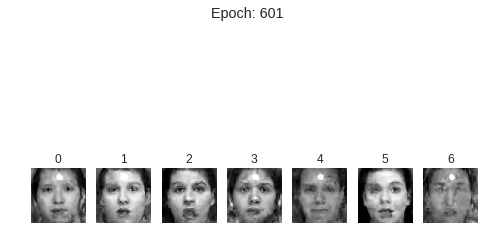

Epoch: 602/1000	Batch: 50/50	D_real_loss: 0.6937164664268494, D_generated_loss: 0.6951488852500916, G_loss: 0.6794847846031189
Epoch: 603/1000	Batch: 50/50	D_real_loss: 0.6911439895629883, D_generated_loss: 0.6991468071937561, G_loss: 0.693536639213562
Epoch: 604/1000	Batch: 50/50	D_real_loss: 0.6835024952888489, D_generated_loss: 0.6884745359420776, G_loss: 0.6917855143547058
Epoch: 605/1000	Batch: 50/50	D_real_loss: 0.6907793879508972, D_generated_loss: 0.6962008476257324, G_loss: 0.6881096959114075
Epoch: 606/1000	Batch: 50/50	D_real_loss: 0.700240969657898, D_generated_loss: 0.690429151058197, G_loss: 0.6949639916419983
Epoch: 607/1000	Batch: 50/50	D_real_loss: 0.6864010691642761, D_generated_loss: 0.6943632960319519, G_loss: 0.6906684637069702
Epoch: 608/1000	Batch: 50/50	D_real_loss: 0.688380777835846, D_generated_loss: 0.6902037858963013, G_loss: 0.6984965205192566
Epoch: 609/1000	Batch: 50/50	D_real_loss: 0.6937958002090454, D_generated_loss: 0.6934583783149719, G_loss: 0.67823

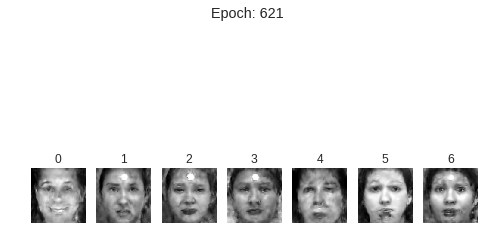

Epoch: 622/1000	Batch: 50/50	D_real_loss: 0.695958137512207, D_generated_loss: 0.692038893699646, G_loss: 0.6964649558067322
Epoch: 623/1000	Batch: 50/50	D_real_loss: 0.6864242553710938, D_generated_loss: 0.6868748068809509, G_loss: 0.6969207525253296
Epoch: 624/1000	Batch: 50/50	D_real_loss: 0.6963338851928711, D_generated_loss: 0.6887688636779785, G_loss: 0.7025752663612366
Epoch: 625/1000	Batch: 50/50	D_real_loss: 0.7032186388969421, D_generated_loss: 0.702501654624939, G_loss: 0.6943141222000122
Epoch: 626/1000	Batch: 50/50	D_real_loss: 0.6842024922370911, D_generated_loss: 0.6997409462928772, G_loss: 0.6933731436729431
Epoch: 627/1000	Batch: 50/50	D_real_loss: 0.6948915123939514, D_generated_loss: 0.689713180065155, G_loss: 0.6881541013717651
Epoch: 628/1000	Batch: 50/50	D_real_loss: 0.688628613948822, D_generated_loss: 0.6934773325920105, G_loss: 0.6996787190437317
Epoch: 629/1000	Batch: 50/50	D_real_loss: 0.6877964735031128, D_generated_loss: 0.6924517750740051, G_loss: 0.695769

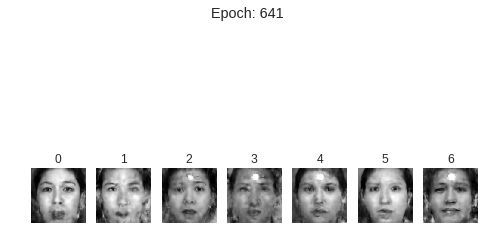

Epoch: 642/1000	Batch: 50/50	D_real_loss: 0.6937326192855835, D_generated_loss: 0.6914664506912231, G_loss: 0.692591667175293
Epoch: 643/1000	Batch: 50/50	D_real_loss: 0.6909414529800415, D_generated_loss: 0.6893768906593323, G_loss: 0.7021194100379944
Epoch: 644/1000	Batch: 50/50	D_real_loss: 0.6985217332839966, D_generated_loss: 0.6925017237663269, G_loss: 0.6798127293586731
Epoch: 645/1000	Batch: 50/50	D_real_loss: 0.6930550932884216, D_generated_loss: 0.6971026062965393, G_loss: 0.6943390965461731
Epoch: 646/1000	Batch: 50/50	D_real_loss: 0.6974115967750549, D_generated_loss: 0.6996668577194214, G_loss: 0.7001018524169922
Epoch: 647/1000	Batch: 50/50	D_real_loss: 0.6957330703735352, D_generated_loss: 0.6773895621299744, G_loss: 0.6818365454673767
Epoch: 648/1000	Batch: 50/50	D_real_loss: 0.6985180974006653, D_generated_loss: 0.6974352598190308, G_loss: 0.7087744474411011
Epoch: 649/1000	Batch: 50/50	D_real_loss: 0.6951876878738403, D_generated_loss: 0.6933253407478333, G_loss: 0.70

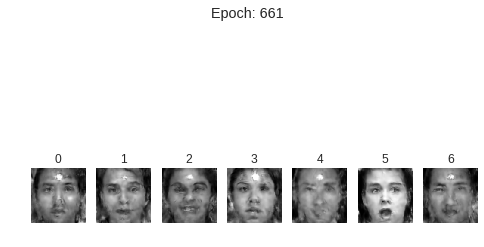

Epoch: 662/1000	Batch: 50/50	D_real_loss: 0.6951949000358582, D_generated_loss: 0.6932442784309387, G_loss: 0.6869021058082581
Epoch: 663/1000	Batch: 50/50	D_real_loss: 0.69063800573349, D_generated_loss: 0.7037278413772583, G_loss: 0.7058207392692566
Epoch: 664/1000	Batch: 50/50	D_real_loss: 0.6919670104980469, D_generated_loss: 0.6860118508338928, G_loss: 0.6930930018424988
Epoch: 665/1000	Batch: 50/50	D_real_loss: 0.6919988989830017, D_generated_loss: 0.6897454261779785, G_loss: 0.6971972584724426
Epoch: 666/1000	Batch: 50/50	D_real_loss: 0.7032591104507446, D_generated_loss: 0.6939032673835754, G_loss: 0.707058846950531
Epoch: 667/1000	Batch: 50/50	D_real_loss: 0.692170262336731, D_generated_loss: 0.681275486946106, G_loss: 0.7121248841285706
Epoch: 668/1000	Batch: 50/50	D_real_loss: 0.6841738820075989, D_generated_loss: 0.6848535537719727, G_loss: 0.6926671862602234
Epoch: 669/1000	Batch: 50/50	D_real_loss: 0.6905864477157593, D_generated_loss: 0.7072354555130005, G_loss: 0.696896

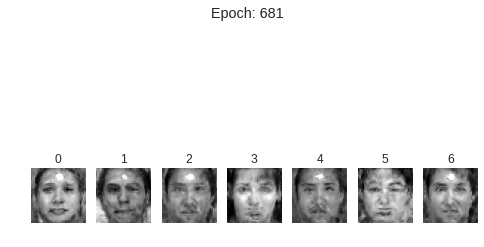

Epoch: 682/1000	Batch: 50/50	D_real_loss: 0.6898271441459656, D_generated_loss: 0.7011455297470093, G_loss: 0.6980369687080383
Epoch: 683/1000	Batch: 50/50	D_real_loss: 0.6932345032691956, D_generated_loss: 0.6910926103591919, G_loss: 0.6901327967643738
Epoch: 684/1000	Batch: 50/50	D_real_loss: 0.6875163912773132, D_generated_loss: 0.6945850253105164, G_loss: 0.6955947875976562
Epoch: 685/1000	Batch: 50/50	D_real_loss: 0.6970439553260803, D_generated_loss: 0.6919698119163513, G_loss: 0.6886432766914368
Epoch: 686/1000	Batch: 50/50	D_real_loss: 0.6850594282150269, D_generated_loss: 0.6874094605445862, G_loss: 0.6968349814414978
Epoch: 687/1000	Batch: 50/50	D_real_loss: 0.6985796689987183, D_generated_loss: 0.6959437727928162, G_loss: 0.6999510526657104
Epoch: 688/1000	Batch: 50/50	D_real_loss: 0.6958685517311096, D_generated_loss: 0.6866641044616699, G_loss: 0.6895829439163208
Epoch: 689/1000	Batch: 50/50	D_real_loss: 0.6994246244430542, D_generated_loss: 0.6972428560256958, G_loss: 0.6

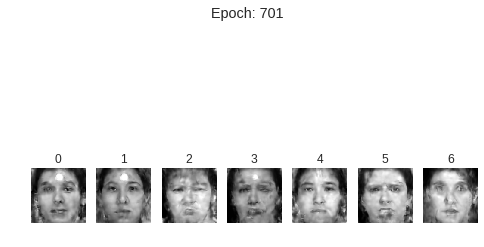

Epoch: 702/1000	Batch: 50/50	D_real_loss: 0.6858269572257996, D_generated_loss: 0.6870231032371521, G_loss: 0.6866756081581116
Epoch: 703/1000	Batch: 50/50	D_real_loss: 0.6969221830368042, D_generated_loss: 0.6885743737220764, G_loss: 0.7015487551689148
Epoch: 704/1000	Batch: 50/50	D_real_loss: 0.6915169954299927, D_generated_loss: 0.6910582184791565, G_loss: 0.6935396194458008
Epoch: 705/1000	Batch: 50/50	D_real_loss: 0.6973978877067566, D_generated_loss: 0.7033238410949707, G_loss: 0.6945616006851196
Epoch: 706/1000	Batch: 50/50	D_real_loss: 0.696491539478302, D_generated_loss: 0.6945425868034363, G_loss: 0.67999267578125
Epoch: 707/1000	Batch: 50/50	D_real_loss: 0.7070356607437134, D_generated_loss: 0.6971806287765503, G_loss: 0.6975594162940979
Epoch: 708/1000	Batch: 50/50	D_real_loss: 0.6920024156570435, D_generated_loss: 0.6899941563606262, G_loss: 0.6965121626853943
Epoch: 709/1000	Batch: 50/50	D_real_loss: 0.6891145706176758, D_generated_loss: 0.6953674554824829, G_loss: 0.7063

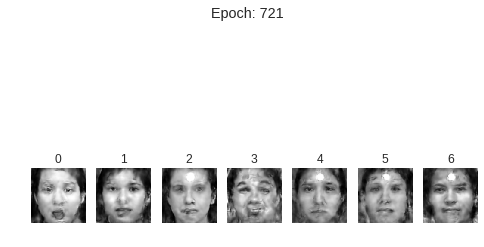

Epoch: 722/1000	Batch: 50/50	D_real_loss: 0.6872126460075378, D_generated_loss: 0.6954536437988281, G_loss: 0.686080813407898
Epoch: 723/1000	Batch: 50/50	D_real_loss: 0.6885722875595093, D_generated_loss: 0.6930832266807556, G_loss: 0.6876085996627808
Epoch: 724/1000	Batch: 50/50	D_real_loss: 0.7015162110328674, D_generated_loss: 0.6938401460647583, G_loss: 0.6945780515670776
Epoch: 725/1000	Batch: 50/50	D_real_loss: 0.7001200914382935, D_generated_loss: 0.6966341733932495, G_loss: 0.6781550645828247
Epoch: 726/1000	Batch: 50/50	D_real_loss: 0.6962546110153198, D_generated_loss: 0.6989359259605408, G_loss: 0.6875457763671875
Epoch: 727/1000	Batch: 50/50	D_real_loss: 0.6946846842765808, D_generated_loss: 0.683528482913971, G_loss: 0.6932652592658997
Epoch: 728/1000	Batch: 50/50	D_real_loss: 0.6958081126213074, D_generated_loss: 0.6949782371520996, G_loss: 0.6936174631118774
Epoch: 729/1000	Batch: 50/50	D_real_loss: 0.7030325531959534, D_generated_loss: 0.700293242931366, G_loss: 0.7016

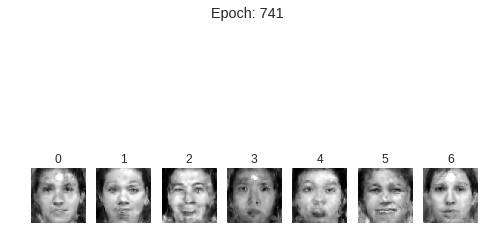

Epoch: 742/1000	Batch: 50/50	D_real_loss: 0.6970499157905579, D_generated_loss: 0.70159912109375, G_loss: 0.6840645670890808
Epoch: 743/1000	Batch: 50/50	D_real_loss: 0.6912345290184021, D_generated_loss: 0.694684624671936, G_loss: 0.6880547404289246
Epoch: 744/1000	Batch: 50/50	D_real_loss: 0.6992931365966797, D_generated_loss: 0.6915388107299805, G_loss: 0.7090586423873901
Epoch: 745/1000	Batch: 50/50	D_real_loss: 0.692478358745575, D_generated_loss: 0.7061318755149841, G_loss: 0.6925339698791504
Epoch: 746/1000	Batch: 50/50	D_real_loss: 0.6864400506019592, D_generated_loss: 0.6898216605186462, G_loss: 0.692499041557312
Epoch: 747/1000	Batch: 50/50	D_real_loss: 0.6863754391670227, D_generated_loss: 0.6947851181030273, G_loss: 0.6918520331382751
Epoch: 748/1000	Batch: 50/50	D_real_loss: 0.687158465385437, D_generated_loss: 0.6889888048171997, G_loss: 0.699214518070221
Epoch: 749/1000	Batch: 50/50	D_real_loss: 0.6913084387779236, D_generated_loss: 0.6925908327102661, G_loss: 0.69609612

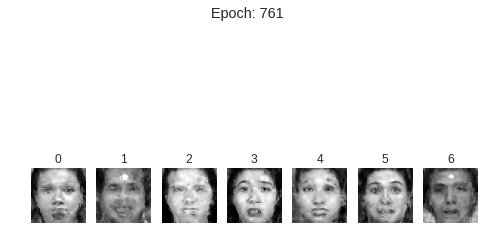

Epoch: 762/1000	Batch: 50/50	D_real_loss: 0.6836830377578735, D_generated_loss: 0.6965808272361755, G_loss: 0.6905884146690369
Epoch: 763/1000	Batch: 50/50	D_real_loss: 0.697039783000946, D_generated_loss: 0.6973488926887512, G_loss: 0.6980801820755005
Epoch: 764/1000	Batch: 50/50	D_real_loss: 0.6985499262809753, D_generated_loss: 0.6968258023262024, G_loss: 0.6911202073097229
Epoch: 765/1000	Batch: 50/50	D_real_loss: 0.6838778257369995, D_generated_loss: 0.6888261437416077, G_loss: 0.7011786699295044
Epoch: 766/1000	Batch: 50/50	D_real_loss: 0.7003578543663025, D_generated_loss: 0.689537525177002, G_loss: 0.6918856501579285
Epoch: 767/1000	Batch: 50/50	D_real_loss: 0.6914963722229004, D_generated_loss: 0.6946843266487122, G_loss: 0.6915302872657776
Epoch: 768/1000	Batch: 50/50	D_real_loss: 0.6995602250099182, D_generated_loss: 0.6958795189857483, G_loss: 0.6934298276901245
Epoch: 769/1000	Batch: 50/50	D_real_loss: 0.6922051310539246, D_generated_loss: 0.6889051795005798, G_loss: 0.684

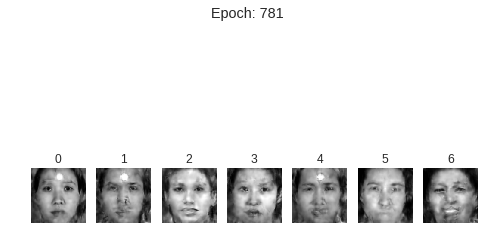

Epoch: 782/1000	Batch: 50/50	D_real_loss: 0.6872084736824036, D_generated_loss: 0.6775277256965637, G_loss: 0.6983436942100525
Epoch: 783/1000	Batch: 50/50	D_real_loss: 0.6917519569396973, D_generated_loss: 0.6920267343521118, G_loss: 0.6910333633422852
Epoch: 784/1000	Batch: 50/50	D_real_loss: 0.6931551098823547, D_generated_loss: 0.6959929466247559, G_loss: 0.6783322691917419
Epoch: 785/1000	Batch: 50/50	D_real_loss: 0.7028898000717163, D_generated_loss: 0.7012112736701965, G_loss: 0.6919884085655212
Epoch: 786/1000	Batch: 50/50	D_real_loss: 0.7014949917793274, D_generated_loss: 0.6854509711265564, G_loss: 0.6856317520141602
Epoch: 787/1000	Batch: 50/50	D_real_loss: 0.6933625936508179, D_generated_loss: 0.672663152217865, G_loss: 0.6900502443313599
Epoch: 788/1000	Batch: 50/50	D_real_loss: 0.6877444386482239, D_generated_loss: 0.6917193531990051, G_loss: 0.7042503356933594
Epoch: 789/1000	Batch: 50/50	D_real_loss: 0.6890398859977722, D_generated_loss: 0.6938979029655457, G_loss: 0.68

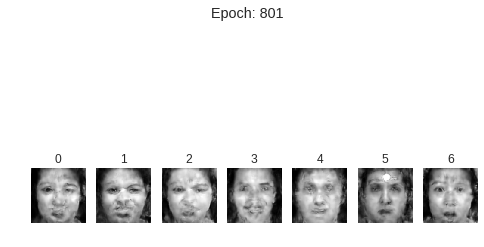

Epoch: 802/1000	Batch: 50/50	D_real_loss: 0.6891378164291382, D_generated_loss: 0.6981518864631653, G_loss: 0.6917349696159363
Epoch: 803/1000	Batch: 50/50	D_real_loss: 0.6927222013473511, D_generated_loss: 0.6959559321403503, G_loss: 0.6943902373313904
Epoch: 804/1000	Batch: 50/50	D_real_loss: 0.6963790059089661, D_generated_loss: 0.6934388279914856, G_loss: 0.6823745965957642
Epoch: 805/1000	Batch: 50/50	D_real_loss: 0.6890189051628113, D_generated_loss: 0.7003240585327148, G_loss: 0.6968455910682678
Epoch: 806/1000	Batch: 50/50	D_real_loss: 0.6884845495223999, D_generated_loss: 0.6985248923301697, G_loss: 0.6857962012290955
Epoch: 807/1000	Batch: 50/50	D_real_loss: 0.6892989277839661, D_generated_loss: 0.6897516846656799, G_loss: 0.6931362152099609
Epoch: 808/1000	Batch: 50/50	D_real_loss: 0.6928673982620239, D_generated_loss: 0.685679018497467, G_loss: 0.6912055611610413
Epoch: 809/1000	Batch: 50/50	D_real_loss: 0.6906308531761169, D_generated_loss: 0.694738507270813, G_loss: 0.685

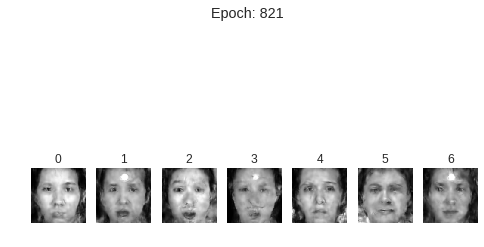

Epoch: 822/1000	Batch: 50/50	D_real_loss: 0.6949812769889832, D_generated_loss: 0.6939668655395508, G_loss: 0.7017855048179626
Epoch: 823/1000	Batch: 50/50	D_real_loss: 0.6940388083457947, D_generated_loss: 0.6940338015556335, G_loss: 0.686976969242096
Epoch: 824/1000	Batch: 50/50	D_real_loss: 0.6936983466148376, D_generated_loss: 0.6861673593521118, G_loss: 0.7031843066215515
Epoch: 825/1000	Batch: 50/50	D_real_loss: 0.6884093880653381, D_generated_loss: 0.6968408226966858, G_loss: 0.6953152418136597
Epoch: 826/1000	Batch: 50/50	D_real_loss: 0.6881670355796814, D_generated_loss: 0.6884778141975403, G_loss: 0.6904491782188416
Epoch: 827/1000	Batch: 50/50	D_real_loss: 0.6902714967727661, D_generated_loss: 0.6977065205574036, G_loss: 0.6937769651412964
Epoch: 828/1000	Batch: 50/50	D_real_loss: 0.6915983557701111, D_generated_loss: 0.6890510320663452, G_loss: 0.6946362257003784
Epoch: 829/1000	Batch: 50/50	D_real_loss: 0.6900381445884705, D_generated_loss: 0.6970698237419128, G_loss: 0.69

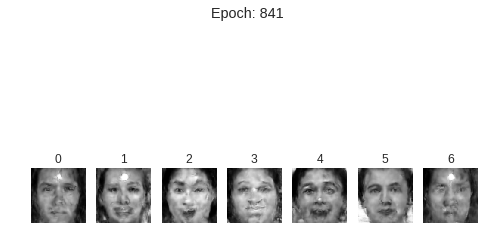

Epoch: 842/1000	Batch: 50/50	D_real_loss: 0.6964141130447388, D_generated_loss: 0.6965869069099426, G_loss: 0.6925719976425171
Epoch: 843/1000	Batch: 50/50	D_real_loss: 0.6923564672470093, D_generated_loss: 0.6919509172439575, G_loss: 0.6844609379768372
Epoch: 844/1000	Batch: 50/50	D_real_loss: 0.6929998993873596, D_generated_loss: 0.6852577328681946, G_loss: 0.7002184987068176
Epoch: 845/1000	Batch: 50/50	D_real_loss: 0.6906241178512573, D_generated_loss: 0.7073710560798645, G_loss: 0.6850947141647339
Epoch: 846/1000	Batch: 50/50	D_real_loss: 0.6912870407104492, D_generated_loss: 0.6887497305870056, G_loss: 0.6858196258544922
Epoch: 847/1000	Batch: 50/50	D_real_loss: 0.6972736716270447, D_generated_loss: 0.6796690821647644, G_loss: 0.6951259970664978
Epoch: 848/1000	Batch: 50/50	D_real_loss: 0.6906333565711975, D_generated_loss: 0.6967472434043884, G_loss: 0.6970272064208984
Epoch: 849/1000	Batch: 50/50	D_real_loss: 0.690007209777832, D_generated_loss: 0.6888562440872192, G_loss: 0.69

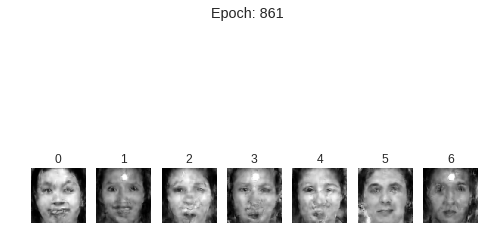

Epoch: 862/1000	Batch: 50/50	D_real_loss: 0.6891838908195496, D_generated_loss: 0.6951153874397278, G_loss: 0.6856766939163208
Epoch: 863/1000	Batch: 50/50	D_real_loss: 0.6876691579818726, D_generated_loss: 0.7038768529891968, G_loss: 0.6945494413375854
Epoch: 864/1000	Batch: 50/50	D_real_loss: 0.6908056139945984, D_generated_loss: 0.6873606443405151, G_loss: 0.685043215751648
Epoch: 865/1000	Batch: 50/50	D_real_loss: 0.6860777139663696, D_generated_loss: 0.6923229098320007, G_loss: 0.6852896809577942
Epoch: 866/1000	Batch: 50/50	D_real_loss: 0.6919498443603516, D_generated_loss: 0.6953142285346985, G_loss: 0.686690628528595
Epoch: 867/1000	Batch: 50/50	D_real_loss: 0.6953424215316772, D_generated_loss: 0.6831216216087341, G_loss: 0.6904179453849792
Epoch: 868/1000	Batch: 50/50	D_real_loss: 0.6961547136306763, D_generated_loss: 0.6823459267616272, G_loss: 0.6927493214607239
Epoch: 869/1000	Batch: 50/50	D_real_loss: 0.6984190344810486, D_generated_loss: 0.6907314658164978, G_loss: 0.691

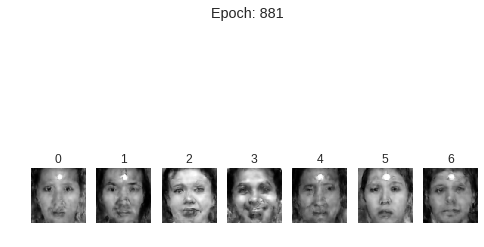

Epoch: 882/1000	Batch: 50/50	D_real_loss: 0.6997905969619751, D_generated_loss: 0.6893959641456604, G_loss: 0.6816681623458862
Epoch: 883/1000	Batch: 50/50	D_real_loss: 0.6939212679862976, D_generated_loss: 0.7016826272010803, G_loss: 0.7037538290023804
Epoch: 884/1000	Batch: 50/50	D_real_loss: 0.6900467276573181, D_generated_loss: 0.6959384679794312, G_loss: 0.7091408967971802
Epoch: 885/1000	Batch: 50/50	D_real_loss: 0.6989607214927673, D_generated_loss: 0.7001326680183411, G_loss: 0.682799756526947
Epoch: 886/1000	Batch: 50/50	D_real_loss: 0.7039081454277039, D_generated_loss: 0.6854931712150574, G_loss: 0.6945552825927734
Epoch: 887/1000	Batch: 50/50	D_real_loss: 0.6932356953620911, D_generated_loss: 0.6950273513793945, G_loss: 0.6939496397972107
Epoch: 888/1000	Batch: 50/50	D_real_loss: 0.696456253528595, D_generated_loss: 0.6999791860580444, G_loss: 0.6937403082847595
Epoch: 889/1000	Batch: 50/50	D_real_loss: 0.6908785700798035, D_generated_loss: 0.693614661693573, G_loss: 0.6974

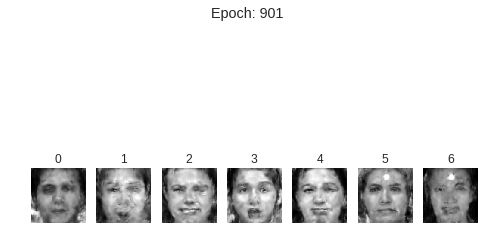

Epoch: 902/1000	Batch: 50/50	D_real_loss: 0.6964473724365234, D_generated_loss: 0.6931971311569214, G_loss: 0.6988126039505005
Epoch: 903/1000	Batch: 50/50	D_real_loss: 0.6948785781860352, D_generated_loss: 0.6946943998336792, G_loss: 0.7003917694091797
Epoch: 904/1000	Batch: 50/50	D_real_loss: 0.6878216862678528, D_generated_loss: 0.6924442648887634, G_loss: 0.691167414188385
Epoch: 905/1000	Batch: 50/50	D_real_loss: 0.6952323913574219, D_generated_loss: 0.6864522099494934, G_loss: 0.7001752257347107
Epoch: 906/1000	Batch: 50/50	D_real_loss: 0.6924448013305664, D_generated_loss: 0.6934703588485718, G_loss: 0.6908745169639587
Epoch: 907/1000	Batch: 50/50	D_real_loss: 0.6930764317512512, D_generated_loss: 0.6884908676147461, G_loss: 0.6878738403320312
Epoch: 908/1000	Batch: 50/50	D_real_loss: 0.6901846528053284, D_generated_loss: 0.6997498869895935, G_loss: 0.6912809014320374
Epoch: 909/1000	Batch: 50/50	D_real_loss: 0.6873540878295898, D_generated_loss: 0.6923421025276184, G_loss: 0.68

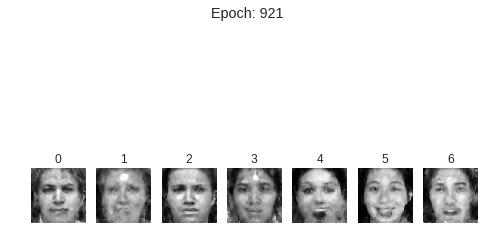

Epoch: 922/1000	Batch: 50/50	D_real_loss: 0.6882151365280151, D_generated_loss: 0.6911134719848633, G_loss: 0.6773110628128052
Epoch: 923/1000	Batch: 50/50	D_real_loss: 0.6974312663078308, D_generated_loss: 0.6892656683921814, G_loss: 0.7011527419090271
Epoch: 924/1000	Batch: 50/50	D_real_loss: 0.6927576065063477, D_generated_loss: 0.6926072239875793, G_loss: 0.699406623840332
Epoch: 925/1000	Batch: 50/50	D_real_loss: 0.695586621761322, D_generated_loss: 0.6937723159790039, G_loss: 0.6851949691772461
Epoch: 926/1000	Batch: 50/50	D_real_loss: 0.689484179019928, D_generated_loss: 0.7029632925987244, G_loss: 0.6900843381881714
Epoch: 927/1000	Batch: 50/50	D_real_loss: 0.6922479867935181, D_generated_loss: 0.6970133781433105, G_loss: 0.6934396028518677
Epoch: 928/1000	Batch: 50/50	D_real_loss: 0.6941457390785217, D_generated_loss: 0.7001948356628418, G_loss: 0.6949865221977234
Epoch: 929/1000	Batch: 50/50	D_real_loss: 0.6870214343070984, D_generated_loss: 0.6929652094841003, G_loss: 0.6906

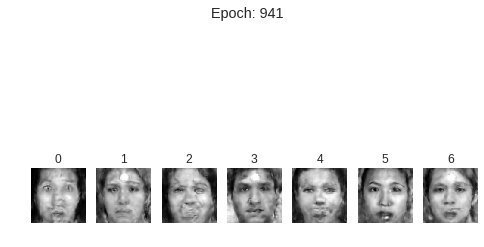

Epoch: 942/1000	Batch: 50/50	D_real_loss: 0.6938984990119934, D_generated_loss: 0.7002558708190918, G_loss: 0.6903384327888489
Epoch: 943/1000	Batch: 50/50	D_real_loss: 0.695171058177948, D_generated_loss: 0.6958271265029907, G_loss: 0.6974749565124512
Epoch: 944/1000	Batch: 50/50	D_real_loss: 0.6935515999794006, D_generated_loss: 0.6910677552223206, G_loss: 0.6962615847587585
Epoch: 945/1000	Batch: 50/50	D_real_loss: 0.6929898858070374, D_generated_loss: 0.6880406141281128, G_loss: 0.6937382817268372
Epoch: 946/1000	Batch: 50/50	D_real_loss: 0.6903595924377441, D_generated_loss: 0.6928033828735352, G_loss: 0.6952490210533142
Epoch: 947/1000	Batch: 50/50	D_real_loss: 0.698420524597168, D_generated_loss: 0.6817464828491211, G_loss: 0.6944876313209534
Epoch: 948/1000	Batch: 50/50	D_real_loss: 0.6877778172492981, D_generated_loss: 0.6876863837242126, G_loss: 0.6826590299606323
Epoch: 949/1000	Batch: 50/50	D_real_loss: 0.6941258311271667, D_generated_loss: 0.6861911416053772, G_loss: 0.689

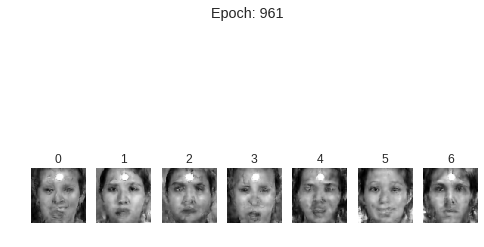

Epoch: 962/1000	Batch: 50/50	D_real_loss: 0.69187992811203, D_generated_loss: 0.6839415431022644, G_loss: 0.6996811628341675
Epoch: 963/1000	Batch: 50/50	D_real_loss: 0.6993662118911743, D_generated_loss: 0.6873452067375183, G_loss: 0.6876055598258972
Epoch: 964/1000	Batch: 50/50	D_real_loss: 0.6933480501174927, D_generated_loss: 0.6850613355636597, G_loss: 0.689380943775177
Epoch: 965/1000	Batch: 50/50	D_real_loss: 0.6945926547050476, D_generated_loss: 0.6962469816207886, G_loss: 0.6973102688789368
Epoch: 966/1000	Batch: 50/50	D_real_loss: 0.6871194839477539, D_generated_loss: 0.6906490325927734, G_loss: 0.6890293955802917
Epoch: 967/1000	Batch: 50/50	D_real_loss: 0.6939069032669067, D_generated_loss: 0.6965039968490601, G_loss: 0.6881099343299866
Epoch: 968/1000	Batch: 50/50	D_real_loss: 0.6912680864334106, D_generated_loss: 0.6867895126342773, G_loss: 0.6982150673866272
Epoch: 969/1000	Batch: 50/50	D_real_loss: 0.6914496421813965, D_generated_loss: 0.6975744962692261, G_loss: 0.7037

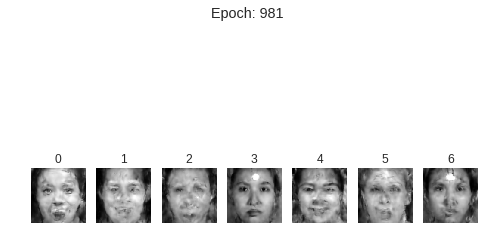

Epoch: 982/1000	Batch: 50/50	D_real_loss: 0.6988171935081482, D_generated_loss: 0.6962588429450989, G_loss: 0.6996143460273743
Epoch: 983/1000	Batch: 50/50	D_real_loss: 0.6927986145019531, D_generated_loss: 0.6938151717185974, G_loss: 0.6835390329360962
Epoch: 984/1000	Batch: 50/50	D_real_loss: 0.6951085925102234, D_generated_loss: 0.6923466324806213, G_loss: 0.6909219026565552
Epoch: 985/1000	Batch: 50/50	D_real_loss: 0.6919201612472534, D_generated_loss: 0.699569046497345, G_loss: 0.6934321522712708
Epoch: 986/1000	Batch: 50/50	D_real_loss: 0.6911730170249939, D_generated_loss: 0.6982056498527527, G_loss: 0.6865682601928711
Epoch: 987/1000	Batch: 50/50	D_real_loss: 0.6958536505699158, D_generated_loss: 0.6997331976890564, G_loss: 0.6975465416908264
Epoch: 988/1000	Batch: 50/50	D_real_loss: 0.6923102140426636, D_generated_loss: 0.6962828040122986, G_loss: 0.6924218535423279
Epoch: 989/1000	Batch: 50/50	D_real_loss: 0.6946977972984314, D_generated_loss: 0.6881064176559448, G_loss: 0.68

In [0]:
D_cripple_counter = 0
G_cripple_counter = 0

for epoch in range(epochs_GAN):
    for batch_num in range(num_batches):
        D_cripple_counter= D_cripple_counter+1
        G_cripple_counter= G_cripple_counter+1
        
        # Train Discriminator on real images
        real_images = X_train_encoded[batch_num*batch_size : (batch_num+1)*batch_size]
        labels = y_train[batch_num*batch_size : (batch_num+1)*batch_size]
        D_real_loss.append(D.train_on_batch([labels, real_images], np.ones((batch_size, 1))-noise_factor*np.random.random((batch_size,1))))
        
        # Train Discriminator on generated images
        noise_data = generate_noise(batch_size, noise_shape)
        random_labels = generate_random_labels(num_classes, batch_size)
        generated_images = G.predict([noise_data, random_labels])
        D_generated_loss.append(D.train_on_batch([random_labels, generated_images],  np.zeros((batch_size, 1))+noise_factor*np.random.random((batch_size,1))))
        
        if G_cripple_counter % 1 == 0:
          # Train Generator
          noise_data = generate_noise(batch_size, noise_shape)
          random_labels = generate_random_labels(num_classes, batch_size)
          G_loss.append(GAN.train_on_batch([noise_data, random_labels, random_labels], np.ones((batch_size, 1))))

          print(f'\rEpoch: {epoch+1}/{epochs_GAN}\tBatch: {batch_num+1}/{num_batches}\tD_real_loss: {D_real_loss[-1]}, D_generated_loss: {D_generated_loss[-1]}, G_loss: {G_loss[-1]}', end='')
    
    print('')
    
    ### Plot sample every 20 epochs
    if epoch % 20 == 0:
        noise = generate_noise(num_classes,noise_shape)
        labels = np.array(pd.get_dummies(range(num_classes)))
        prediction = decoder.predict(G.predict([noise, labels]))
        plt.figure()
        plt.suptitle(f'Epoch: {epoch+1}')
        for i in range(num_classes):
            plt.subplot(1,num_classes,i+1)
            plt.title(f'{i}')
            plt.imshow(prediction[i,:,:,0]*(-1), cmap=plt.cm.binary) # *-1 because plt inverts colors for some reason (255 is black)
            plt.axis('off')
        plt.show()
            #plt.savefig(f'Generated/{generated_images_folder_name}/Epoch_{epoch+1}')

In [0]:
num_examples = 10
offset=0
prediction = auto_encoder.predict(X_train[offset:offset+num_examples])
for i in range(num_examples):
    plt.figure()
    plt.imshow(prediction[i,:,:,0]*(-1), cmap=plt.cm.binary) # *-1 because plt inverts colors for some reason (255 is black)
    plt.axis('off')
    plt.show()

NameError: ignored

In [0]:
num_examples = 10
prediction = auto_encoder.predict(np.random.normal(0,1,(num_examples,img_shape[0], img_shape[1], 1)))
for i in range(num_examples):
    plt.figure()
    plt.imshow(prediction[i,:,:,0]*(-1), cmap=plt.cm.binary) # *-1 because plt inverts colors for some reason (255 is black)
    plt.axis('off')
    plt.show()

In [0]:
num_examples = 10
prediction = decoder.predict(np.random.normal(0,1,(num_examples,encoding_shape)))
for i in range(num_examples):
    plt.figure()
    plt.imshow(prediction[i,:,:,0]*(-1), cmap=plt.cm.binary) # *-1 because plt inverts colors for some reason (255 is black)
    plt.axis('off')
    plt.show()

In [0]:
num_examples = 100
prediction = decoder.predict(np.random.normal(0,1,(num_examples,encoding_shape)))
plt.figure()
for i in range(num_examples):
    plt.subplot(10,10,i+1)
    plt.imshow(prediction[i,:,:,0]*(-1), cmap=plt.cm.binary) # *-1 because plt inverts colors for some reason (255 is black)
    plt.axis('off')
plt.show()

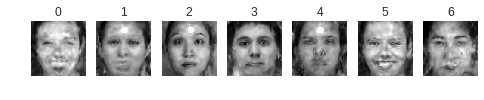

In [0]:
#Testing
num_examples = 1
noise = generate_noise(num_classes*num_examples,noise_shape)
labels = np.array(pd.get_dummies(list(range(num_classes))*num_examples))
prediction = decoder.predict(G.predict([noise, labels]))

plt.close('all')
fig = plt.figure()
for i in range(num_classes*num_examples):
    plt.subplot(num_examples,num_classes,i+1)
    plt.title(f'{i}')
    plt.imshow(prediction[i,:,:,0]*(-1), cmap=plt.cm.binary) # *-1 because plt inverts colors for some reason (255 is black)
    plt.axis('off')
plt.show()

In [0]:
#Testing
num_examples = 10
noise = generate_noise(num_classes*num_examples,noise_shape)
labels = np.array(pd.get_dummies(list(range(num_classes))*num_examples))
prediction = decoder.predict(G.predict([noise, labels]))

for i in range(num_classes*num_examples):
  plt.figure()
  plt.imshow(prediction[i,:,:,0]*(-1), cmap=plt.cm.binary)
  plt.show()

In [0]:
# os.makedirs(f'data')
# os.makedirs(f'large_data')
#os.makedirs(f'data_3')
!unzip large_data.zip

Archive:  large_data.zip
   creating: large_data/
  inflating: large_data/ck_S005_0.jpg  
  inflating: large_data/ck_S005_6.jpg  
  inflating: large_data/ck_S010_0.jpg  
  inflating: large_data/ck_S010_1.jpg  
  inflating: large_data/ck_S010_3.jpg  
  inflating: large_data/ck_S010_4.jpg  
  inflating: large_data/ck_S011_0.jpg  
  inflating: large_data/ck_S011_1.jpg  
  inflating: large_data/ck_S011_2.jpg  
  inflating: large_data/ck_S011_3.jpg  
  inflating: large_data/ck_S011_4.jpg  
  inflating: large_data/ck_S011_5.jpg  
  inflating: large_data/ck_S011_6.jpg  
  inflating: large_data/ck_S014_0.jpg  
  inflating: large_data/ck_S014_1.jpg  
  inflating: large_data/ck_S014_2.jpg  
  inflating: large_data/ck_S014_3.jpg  
  inflating: large_data/ck_S014_4.jpg  
  inflating: large_data/ck_S022_0.jpg  
  inflating: large_data/ck_S022_3.jpg  
  inflating: large_data/ck_S022_4.jpg  
  inflating: large_data/ck_S022_6.jpg  
  inflating: large_data/ck_S026_0.jpg  
  inflating: large_data/ck_S02

In [0]:
!rm -rf large_data